In [2]:
import argparse
import json
import os
import random
from datasets import load_from_disk
from loguru import logger
from tqdm import tqdm
from PIL import Image
import re
from datasets import DatasetDict, Dataset
import pandas as p
from datasets import load_dataset

In [7]:
datasets = load_dataset("cifar10")

In [48]:
# Load CIFAR-10 dataset
datasets = load_dataset("cifar10")

# Get the label names and their corresponding IDs
label_names = datasets["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(label_names):
    label2id[label] = i
    id2label[i] = label

# Initialize dict to store indexes of each class
class_ids = {}
for label in label_names:
    class_ids[label] = []

# Create list of indexes for each class
labels = datasets['train']['label']
for i in range(len(labels)):
    class_name = id2label[labels[i]]
    class_ids[class_name].append(i)

In [84]:
grid = """| bird | bird | bird |
| deer | bird | cat |
| bird | dog | bird |"""


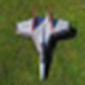

In [93]:
Image.open('/home/allanz/data/images/airplane/40.png').resize((256//3, 256//3), Image.Resampling.LANCZOS)

In [86]:
import numpy as np
import torch
import torch.nn as nn
from datasets import load_from_disk
from loguru import logger
from PIL import Image
from transformers import AutoTokenizer, GPTJForCausalLM
from lmm_synthetic.mm_train.gptj_vlm import GPTJ_VLM
from lmm_synthetic.mm_train.utils import load_vision_encoder
import time

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths 
dataset_path = '/data/lmm/generated/v3_spatial_grid_multimodal'
vlm_path = '/home/allanz/data/vlm_checkpoint/final_model'
lm_path = "/data/lmm/checkpoints/lm/lm-pretrain-only-checkpoint-1953"

# Load dataset
dataset_old = load_from_disk(dataset_path)
print(dataset_old)

# Load VLM and CLIP model
def load_model_and_tokenizer(model_path, multimodal=False):
    """
    Load the model and tokenizer from the specified path.
    """
    logger.info(f"Loading model and tokenizer from {model_path}")
    model, tokenizer = None, None
    if multimodal:
        model = GPTJ_VLM.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model.config.pretrained_lm_path)
    else:
        model = GPTJForCausalLM.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()
    return model, tokenizer

vlm, vlm_tokenizer = load_model_and_tokenizer(vlm_path, multimodal=True)

clip_vision_model = vlm.vision_encoder.clip_vision_model
encoder, image_transforms, _ = load_vision_encoder("clip")

#Parse grid
def parse_grid(grid_str, K):
    """
    Parse the grid string into a 2D list of grid cells.
    """
    grid_str = '\n'.join(grid_str.split('\n')[:K])
    rows = grid_str.strip().split('\n')
    return [[cell.strip() for cell in row.split('|') if cell.strip()] for row in rows]

2024-12-19 04:01:55.538 | INFO     | __main__:load_model_and_tokenizer:28 - Loading model and tokenizer from /home/allanz/data/vlm_checkpoint/final_model


DatasetDict({
    train: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 100000
    })
    validation: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 1000
    })
})


2024-12-19 04:01:57.464 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:26 - Loading vision encoder: clip
2024-12-19 04:01:57.466 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:29 - Using CLIP model as the vision encoder
/home/allanz/miniconda3/envs/vlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-12-19 04:01:57.984 | INFO     | lmm_synthetic.mm_train.utils:load_multimodal_projector:89 - Loading multimodal projector: linear
2024-12-19 04:01:58.297 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:26 - Loading vision encoder: clip
2024-12-19 04:01:58.298 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:29 - Using CLIP model as the vision encoder


In [88]:
old_grid = parse_grid(dataset_old["train"][0]['text'], 3)

In [89]:
old_grid

[['deer', 'cat', 'bird'], ['deer', 'cat', 'cat'], ['bird', 'dog', 'bird']]

In [97]:
label_folder = {}
for label in label_names:
    label_folder[label] = f'/home/allanz/data/images/{label}'

print(label_folder)

{'airplane': '/home/allanz/data/images/airplane', 'automobile': '/home/allanz/data/images/automobile', 'bird': '/home/allanz/data/images/bird', 'cat': '/home/allanz/data/images/cat', 'deer': '/home/allanz/data/images/deer', 'dog': '/home/allanz/data/images/dog', 'frog': '/home/allanz/data/images/frog', 'horse': '/home/allanz/data/images/horse', 'ship': '/home/allanz/data/images/ship', 'truck': '/home/allanz/data/images/truck'}


In [100]:
print(label_folder['airplane'] + "/hello")

/home/allanz/data/images/airplane/hello


In [110]:
BORDER_SIZE = 6

def merge_image(grid, final_size=(256, 256), num_unique_images = 1000):
    # Determine the number of rows and columns
    rows = len(grid)
    cols = len(grid[0]) if rows > 0 else 0
    
    # Calculate available width and height for each image
    total_border_width = (cols - 1) * BORDER_SIZE
    total_border_height = (rows - 1) * BORDER_SIZE
    available_width = final_size[0] - total_border_width
    available_height = final_size[1] - total_border_height
    element_width = available_width // cols
    element_height = available_height // rows
    
    # Create the new image with a black background
    combined_image = Image.new('RGB', final_size, 'black')
    
    # Place each image in the combined image
    for row_index, row in enumerate(grid):
        for col_index, word in enumerate(row):
            i = random.randint(0, num_unique_images)
            img = Image.open(f"/home/allanz/data/images/{word}/{i}.png").resize((256//3, 256//3), Image.Resampling.LANCZOS)
            x = col_index * (element_width + BORDER_SIZE)
            y = row_index * (element_height + BORDER_SIZE)
            combined_image.paste(img, (x, y))
    
    return combined_image

In [123]:
merged_image = merge_image(old_grid)    

In [113]:
old_grid

[['deer', 'cat', 'bird'], ['deer', 'cat', 'cat'], ['bird', 'dog', 'bird']]

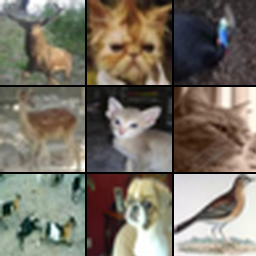

In [124]:
merged_image

In [137]:
parse_grid(dataset_old["validation"][40]['text'], 3)

[['frog', 'truck', 'automobile'],
 ['truck', 'horse', 'truck'],
 ['deer', 'horse', 'truck']]

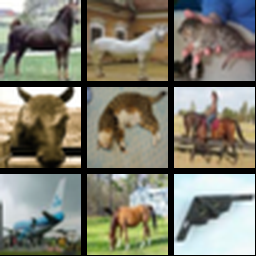

In [130]:
Image.open('/home/allanz/data/grid/train/40.png')